# Exploring band-limited spectral coherence in 1 second windows to detect/anticipate seizures

This uses custom hanning-taper-based code that calculates the mean coherence between the onset channel and all other channels in a one second moving window. It is different from standard approaches in that it does not require multiple trials (instead we use multiple channels).

There is not a a clear peri-onset change in coherence with all other channels. You do see a drop in coherence after onset though which eventually becomes a pronounced increase in coherence (esp in the high gamma band).

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
#import mne
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
# Import Clinical Szr Onset Times
sub='NA'
if sys.platform=='linux':
    onset_csv_dir='/home/dgroppe/TWH_INFO/ONSET_TIMES_CLINICAL'
else:
    onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/ONSET_TIMES_CLINICAL/'
#onset_csv_dir='ONSET_TIMES_CLINICAL/'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinical_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/ONSET_TIMES_CLINICAL/NA_clinical_onset_offset.csv


In [4]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0


In [5]:
def clin_onset_tpt(szr_name, onset_df):
    import re
    name_splt=szr_name.split('_')
    day=int(name_splt[1][1:])
    szr=int(re.findall('[0-9]+',name_splt[2])[0])
    print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

    # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
    day_ids=onset_df[onset_df['DAY']==day].index 
    szr_ids=onset_df[onset_df['SZR#']==szr].index 
    use_id=day_ids.intersection(szr_ids)
    onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
    return onset_tpt

szr_name='NA_d1_sz2.mat'
onset_tpt=clin_onset_tpt(szr_name, onset_df)

Getting clinical onset time for NA: Day 1, Szr 2


In [6]:
# Import Data
szr_name='NA_d1_sz2.mat'
if sys.platform=='linux':
    ieeg_root='/home/dgroppe/TWH_EEG'
else:
    ieeg_root='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'
ieeg_dir=os.path.join(ieeg_root,sub,'Data')
ieeg_fname=os.path.join(ieeg_dir,szr_name)
print('Loading %s' % ieeg_fname)
mat=scipy.io.loadmat(ieeg_fname)
temp=mat['Sf'][0]
Sf=temp[0]
ieeg=mat['matrix_bi']
ieeg=ieeg.T
n_chan, n_tpt=ieeg.shape
tpts_sec=np.arange(0,n_tpt)/Sf
tpts_sec=tpts_sec.T
# Import Channel Labels
chan_fname=os.path.join(ieeg_root,sub,
                        sub+'_channel_info.csv')
print('Loading %s' % chan_fname)
chan_labels_df=pd.read_csv(chan_fname,names=['label'])
# Convert to list and remove redundant electrode stem for second electrode in each bipolar pair
chan_labels=ief.clean_labels(list(chan_labels_df['label']))

onset_chan_id=12; #RHD1-2
contralat_chan_id=0; #LHD1-2

Loading /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/Data/NA_d1_sz2.mat
Loading /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/NA_channel_info.csv


In [7]:
# List channel names
for ct, chan_str in enumerate(chan_labels):
    print('%d: %s' % (ct,chan_str))

0: LHD1-2
1: LHD2-3
2: LHD3-4
3: LAT1-2
4: LAT2-3
5: LAT3-4
6: LMT1-2
7: LMT2-3
8: LMT3-4
9: LPT1-2
10: LPT2-3
11: LPT3-4
12: RHD1-2
13: RHD2-3
14: RHD3-4
15: RAT1-2
16: RAT2-3
17: RAT3-4
18: RMT1-2
19: RMT2-3
20: RMT3-4
21: RSPT1-2
22: RSPT2-3
23: RSPT3-4
24: RSPT4-5
25: RSPT5-6
26: RIPT1-2
27: RIPT2-3
28: RIPT3-4
29: RIPT4-5
30: RIPT5-6


Onset window is marked by vertical black dashed lines


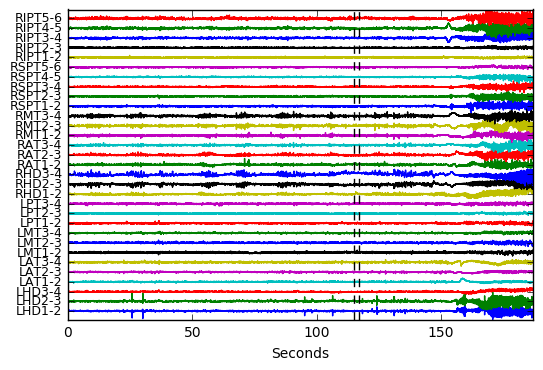

In [8]:
# Plot voltage time series and onset
[h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)

onset_upper_bnd_sec=(onset_tpt/Sf)+1
onset_lower_bnd_sec=(onset_tpt/Sf)-1
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')

print('Onset window is marked by vertical black dashed lines')

Onset time is marked with vertical white dashed lines


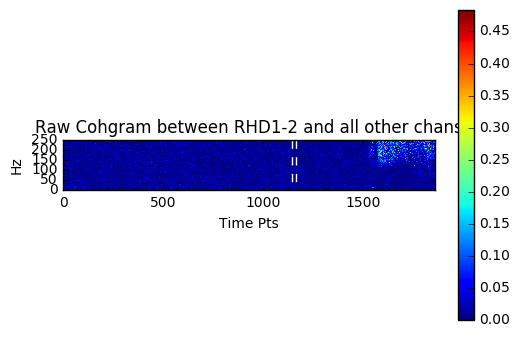

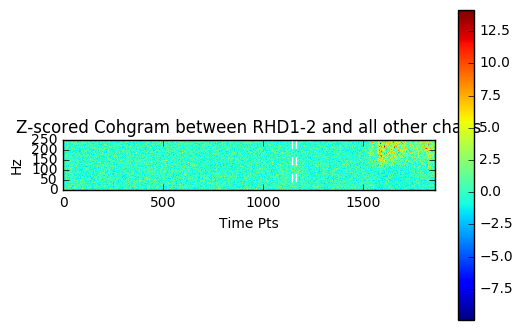

In [44]:
imp.reload(ief) 

# Compute cohgram between RHD1-2 and all other channels
cohgram, f, cohgram_sec=ief.omni_cohgram(ieeg,onset_chan_id,Sf,Sf,Sf/10,tpts_sec)

# Raw Cohgram
plt.figure(10)
plt.clf()
plt.imshow(cohgram)
#plt.imshow(dg.asin_trans(cohgram))
onset_cohgram_tpt_lower=dg.find_nearest(cohgram_sec,onset_lower_bnd_sec)
onset_cohgram_tpt_upper=dg.find_nearest(cohgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_cohgram_tpt_upper, onset_cohgram_tpt_upper],ylim,'w--')
plt.plot([onset_cohgram_tpt_lower, onset_cohgram_tpt_lower],ylim,'w--')
plt.ylim(ylim)
plt.xlim([0,len(cohgram_sec)])
plt.ylabel('Hz')
plt.xlabel('Time Pts')
plt.gca().invert_yaxis()
plt.title('Raw Cohgram between '+chan_labels[onset_chan_id]+' and all other chans')
plt.colorbar()

# Z-scored Cohgram
cohgram_z=dg.asin_trans(cohgram.copy())
ief.z_norm(cohgram_z, cohgram_sec, onset_lower_bnd_sec)
plt.figure(11)
plt.clf()
plt.imshow(cohgram_z)
ylim=plt.ylim()
plt.plot([onset_cohgram_tpt_upper, onset_cohgram_tpt_upper],ylim,'w--')
plt.plot([onset_cohgram_tpt_lower, onset_cohgram_tpt_lower],ylim,'w--')
plt.ylim(ylim)
plt.xlim([0,len(cohgram_sec)])
plt.ylabel('Hz')
plt.xlabel('Time Pts')
plt.gca().invert_yaxis()
plt.title('Z-scored Cohgram between '+chan_labels[onset_chan_id]+' and all other chans')
plt.colorbar()

print('Onset time is marked with vertical white dashed lines')

In [47]:
# Define frequency bands
bands=list()
bands.append((1,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,Sf*.4)) # High Gamma (this skips 60 Hz DC and accommodates analog acquisition filter, 
# 40% of Sf is max freq you want to examine)
n_band=len(bands)
band_labels=['Delta','Theta','Alpha','Beta','Gamma','High Gamma']

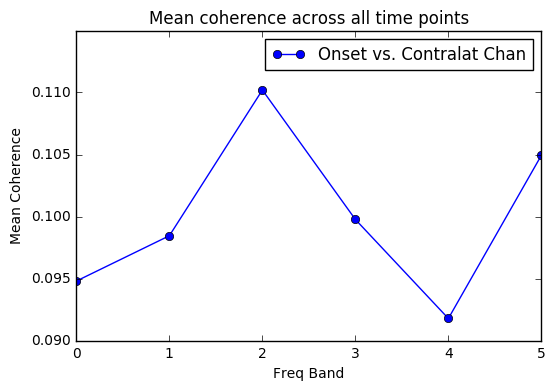

In [45]:
# Avg coherence by freq band
# Note that coherence values are arcsin transformed before averaging
[bp_coh, bp_coh_sec]=ief.bp_coh_omni(ieeg,onset_chan_id,Sf,Sf,int(Sf/10),tpts_sec,bands)

# convert coherence values to percentiles based on pre-onset stats
onset_bp_coh_tpt_upper=dg.find_nearest(bp_coh_sec,onset_upper_bnd_sec)
bp_ptile=np.zeros((n_band,onset_bp_coh_tpt_upper))
for band_loop in range(n_band):
    bp_ptile[band_loop,:]=[stats.percentileofscore(bp_coh[band_loop,:onset_bp_coh_tpt_upper],
                                      a, 'rank') for a in bp_coh[band_loop,:onset_bp_coh_tpt_upper]]

mn_coh=np.mean(bp_coh,axis=1)
plt.plot(mn_coh,'-o',label='Onset vs. Contralat Chan')
plt.xlabel('Freq Band')
plt.ylabel('Mean Coherence')
plt.legend(loc='upper right')
plt.title('Mean coherence across all time points')

Lower bound of onset window is marked with vertical dashed line.


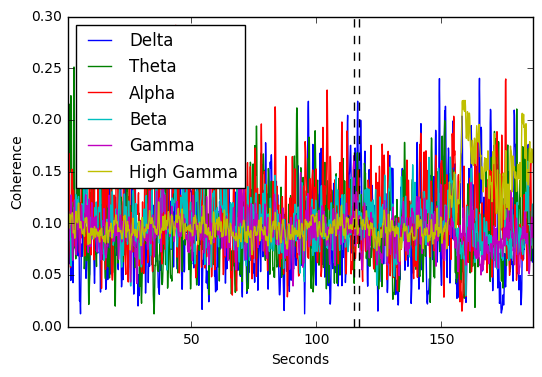

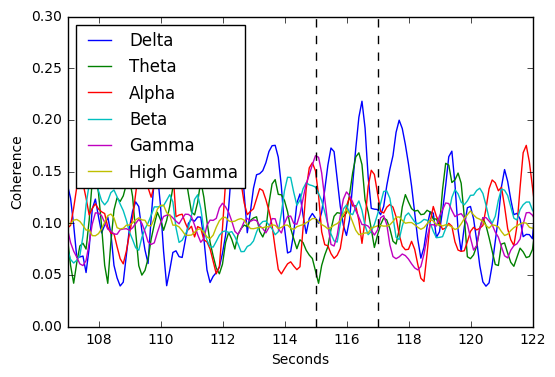

In [48]:
# Plot bandlimited raw coherence time series 

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], bp_coh_sec[-1]])
#plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Coherence')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Coherence')

print('Lower bound of onset window is marked with vertical dashed line.')

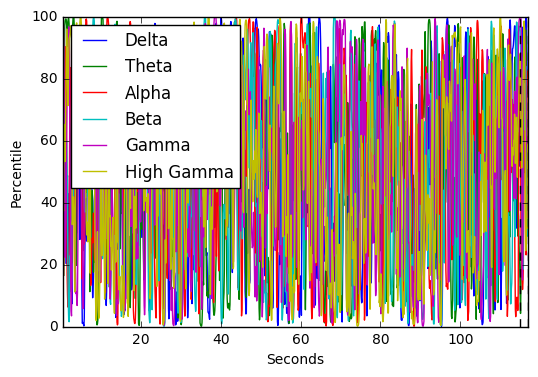

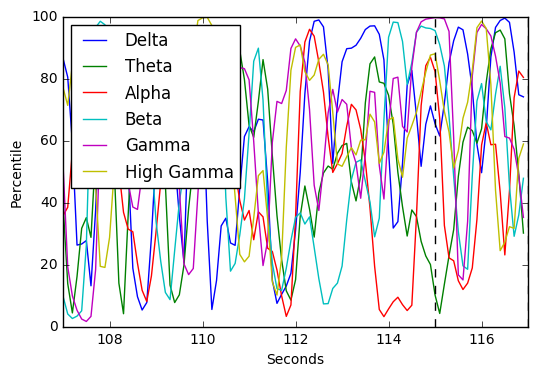

In [25]:
# Plot bandlimited coherence time series with Percentile Normalization

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],bp_ptile.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Percentile')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],bp_ptile.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Percentile')


Lower bound of onset window is marked with vertical dashed line.


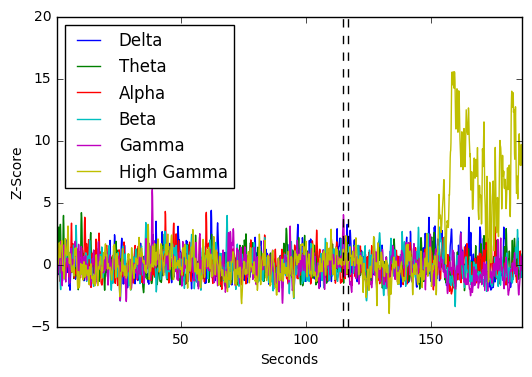

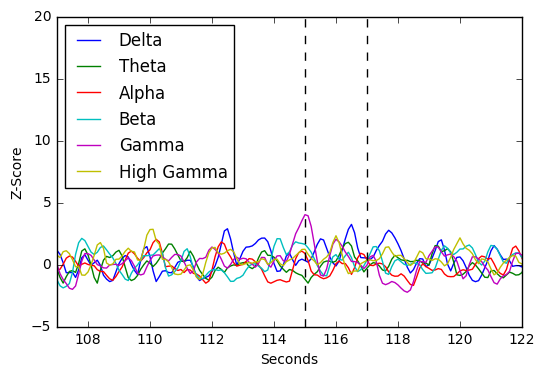

In [49]:
# Plot bandlimited coherence time series with baseline z-score Normalization

# z-score coherence based on pre-onset stats
bp_coh_z=bp_coh.copy()
ief.z_norm(bp_coh_z, bp_coh_sec, onset_lower_bnd_sec)

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh_z.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
#plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec+5])
plt.xlim([bp_coh_sec[0], bp_coh_sec[-1]])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Z-Score')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh_z.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Z-Score')

print('Lower bound of onset window is marked with vertical dashed line.')

In [28]:
# Define 1 giant freq band
# Define frequency bands
big_band=list()
big_band.append((0,Sf*.4))
n_big_band=len(big_band)
band_labels=['0-200 Hz']

In [30]:
# Avg coherence by freq band
[big_bp_coh, big_bp_coh_sec]=ief.bp_coh_omni(ieeg,onset_chan_id,
                               Sf,Sf,int(Sf/10),tpts_sec,big_band)

# convert coherence values to percentiles based on pre-onset stats
onset_bp_coh_tpt_upper=dg.find_nearest(big_bp_coh_sec,onset_upper_bnd_sec)
big_bp_ptile=np.zeros((n_big_band,onset_bp_coh_tpt_upper))
for band_loop in range(n_big_band):
    big_bp_ptile[band_loop,:]=[stats.percentileofscore(big_bp_coh[band_loop,:onset_bp_coh_tpt_upper],
                                      a, 'rank') for a in big_bp_coh[band_loop,:onset_bp_coh_tpt_upper]]

print('Mean 0-200 Hz coherence: %f' % np.mean(big_bp_coh,axis=1))

Mean 0-200 Hz coherence: 0.101603


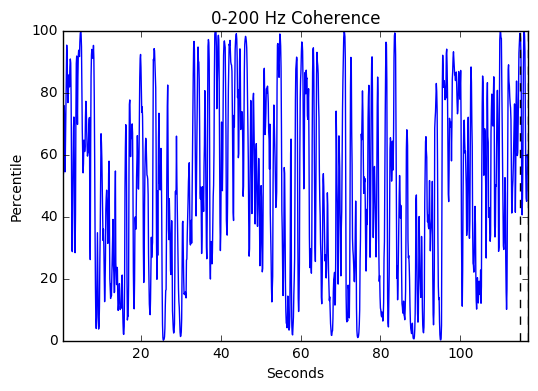

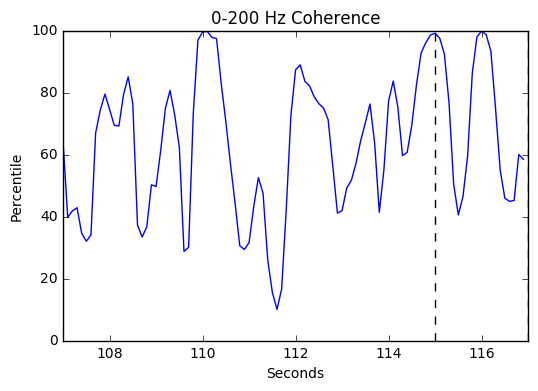

In [31]:
# Plot bandlimited coherence time series with Percentile Normalization

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],big_bp_ptile.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec])
plt.xlabel('Seconds')
plt.ylabel('Percentile')
plt.title('0-200 Hz Coherence')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],big_bp_ptile.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec])
plt.xlabel('Seconds')
plt.ylabel('Percentile')
plt.title('0-200 Hz Coherence')

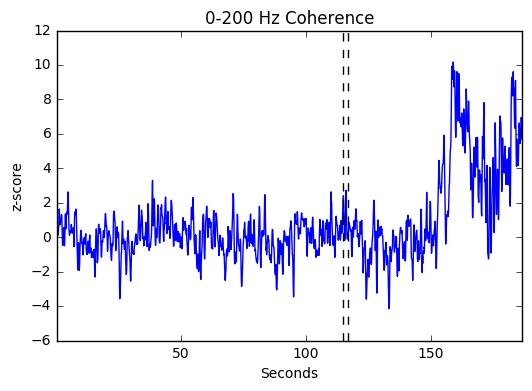

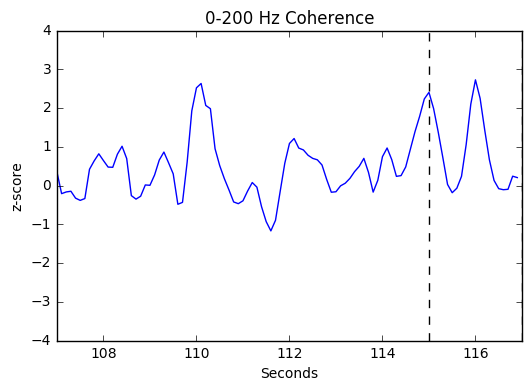

In [43]:
# Plot bandlimited coherence time series with z-score Normalization

# z-score coherence based on pre-onset stats
big_bp_coh_z=big_bp_coh.copy()
ief.z_norm(big_bp_coh_z, bp_coh_sec, onset_lower_bnd_sec)

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec,big_bp_coh_z[0,:])
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], bp_coh_sec[-1]])
plt.xlabel('Seconds')
plt.ylabel('z-score')
plt.title('0-200 Hz Coherence')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],big_bp_coh_z[0,:onset_bp_coh_tpt_upper])
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec])
plt.xlabel('Seconds')
plt.ylabel('z-score')
plt.title('0-200 Hz Coherence')